# Load and prepare data

In [1]:
# After uploading the zip data file, unzip it
# Uploading can take a while
!unzip data.zip

'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [2]:
import pathlib
import os
import numpy as np
import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import IPython.display as display

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD


from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

C:\Users\benja\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\benja\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\benja\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\benja\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


The objective in this notebook is to manipulate pre-trained networks and have a clear understanding of the benefits of transfer learning.

## Load images

The problem we are trying to solve here is to classify RGB  images into their 2 categories ("Puma" or "Nike") by taking advantage of transfer learning. 

For this exercice you will work with MobileNetV2.

First look at the structure of the data

In [3]:
data_root = pathlib.Path("./data/")
for item in data_root.iterdir():
      print(item)

data\Nike
data\Puma


Let's list all the images' path : 

In [4]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

DATASET_SIZE = len(all_image_paths)
print("# images : ", DATASET_SIZE,"\n")
print("Extract of image paths : \n", all_image_paths[:4])

# images :  1999 

Extract of image paths : 
 ['data\\Puma\\001026.jpg', 'data\\Nike\\000825.jpg', 'data\\Puma\\000752.jpg', 'data\\Puma\\000071.jpg']


## Determine label for each image

From the structure of the folder we are able to identify the different labels : 

In [5]:
# List all the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Nike', 'Puma']

Let's map these labels to indexes and keep track of it in dictionnaries:

In [6]:
# Assign an index to each label in a dictionnary: 
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = {v: k for k, v in label_to_index.items()}

print("Label to Index : ", label_to_index, "\nIndex to Label : ", index_to_label)

Label to Index :  {'Nike': 0, 'Puma': 1} 
Index to Label :  {0: 'Nike', 1: 'Puma'}


Now let's define the correct index to each image path :

In [7]:
# Associate an image to an index label (as an integer)
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 0, 1, 1, 0, 0, 1, 1, 1, 0]


## Inspect the images

Let's have a look on a few images : 

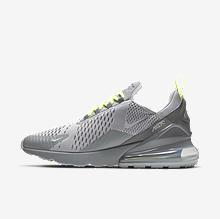

index :  0  - Label :  Nike


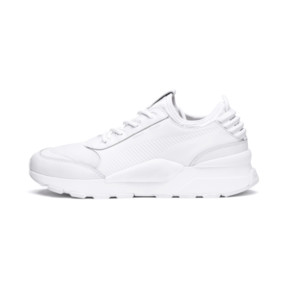

index :  1  - Label :  Puma


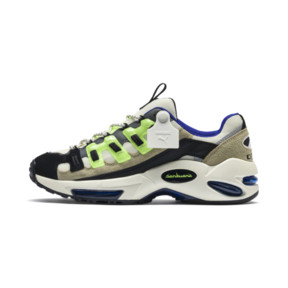

index :  1  - Label :  Puma


In [8]:
for n in range(3):
    index = random.randint(0, DATASET_SIZE)
    image_path, image_label = all_image_paths[index], all_image_labels[index]
    display.display(display.Image(image_path))
    print("index : ", image_label, " - Label : ", index_to_label[image_label])

## Build a dataset

Now let's build a tf.data.Dataset from the list of images and labels associated.

In this exerice you will use 80% of your data in the training and save the last 20% of them for the test.

In [9]:
p = 0.8
train_size = int(p * DATASET_SIZE)
test_size = DATASET_SIZE - train_size

print("# images : ", DATASET_SIZE,"\n")
print("Train size : ", train_size, "\nTest size : ",test_size)

# images :  1999 

Train size :  1599 
Test size :  400


We have implemented the input preprocessing function, composed of the following steps :
- read the file as an image
- decode the jpeg file, setting the number of channels at 3 as it's a RGB image
- resize the image in (224,224) as required in MobileNetV2 specifications
- cast image to float32
- divide image values by 255
- one_hot encoding of the label

Documentation : 
- https://www.tensorflow.org/api_docs/python/tf/io/read_file
- https://www.tensorflow.org/versions/r1.11/api_docs/python/tf/image/decode_jpeg
- https://www.tensorflow.org/api_docs/python/tf/dtypes/cast
- https://www.tensorflow.org/api_docs/python/tf/math/divide
- https://www.tensorflow.org/api_docs/python/tf/one_hot/


In [10]:
IMG_SIZE = 224
NUM_CAT = 2

def _preprocess_inputs(img_path, label):
    # Convert path to image
    image = tf.io.read_file(img_path)
    
    # Resize images
    img_resized = tf.image.decode_jpeg(image, channels=3)
    img_resized = tf.image.resize(img_resized, (IMG_SIZE,IMG_SIZE))

    # Cast image to float32
    img_float = tf.cast(img_resized, tf.float32)
    
    # Divide image values by 255
    img_norm = tf.divide(img_float, 255)
   
    label_one_hot = tf.one_hot(label,depth=NUM_CAT)
    return img_norm, label_one_hot

We now use tf.data to create the input data pipeline. It will be composed of the following steps :

- Create the Dataset. Since we already have in-memory data, we will use the from_tensor_slices function
- map the dataset with the preprocessing function implemented above
- map the result with the image augmentation function
- Add the shuffle, repeat, batch and prefect steps to configure training

Implement the input data pipeline with the above descriptions for the training set

Documentation :

- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = DATASET_SIZE

# Build a tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices((all_image_paths[:train_size], all_image_labels[:train_size]))
# Map for input preprocessing
ds_train = ds_train.map(_preprocess_inputs)
# Shuffle / Repeat / Batch / Prefetch
ds_train = ds_train.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE).prefetch(1)

The input data pipeline for the test set is quite similar, except there is no need to use the repeat and prefetch steps. Moreover, the image augmentation phase is not necessary for the test set, as we want the real images to be used to evaluate the results.

Here the input data pipeline for the test set : 

In [12]:
# Build a dataset
ds_test = tf.data.Dataset.from_tensor_slices((all_image_paths[train_size:], all_image_labels[train_size:]))
# Map
ds_test = ds_test.map(_preprocess_inputs)
# Shuffle / Batch
ds_test = ds_test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Custom model

## Define the model

Using what we have learned so far, build a model that can distinguish a Nike shoe from a Puma one

In [13]:
#Example of a basic CNN model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
dropout_rate = 0.5

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(dropout_rate/2.))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(dropout_rate/2.))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(NUM_CAT, activation='softmax'))

You can have a look at your model : 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

## Compile the model

In [15]:
model.compile(
              optimizer=SGD(lr=1e-2, momentum=0.9, decay=1e-6),
              loss='categorical_crossentropy', 
              metrics=["acc"]
             )

## Train the model

In [16]:
NUM_EPOCHS = 10

history= model.fit(ds_train,
                   epochs=NUM_EPOCHS,
                   steps_per_epoch=int(train_size / BATCH_SIZE),
                   validation_data=ds_test,
                   validation_steps=int(test_size / BATCH_SIZE),
                  )

Train for 49 steps, validate for 12 steps
Epoch 1/10
 1/49 [..............................] - ETA: 5:10

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-16-7c9cb4476036>:7) ]] [Op:__inference_distributed_function_1754]

Function call stack:
distributed_function


## Plot the results

Now you can analyse the performance of your algorithm : 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Start real transfer learning : load a pre-trained model AND download the weights
## Load the pretrained model

This time you will use the pre-trained algorithm and fine tune it.
It means you will load the weights of the algorithm learned when it was trained on ImageNet images and add layers on top of the model.

Change the parameters with the following ones : 
- input shape : (224,224,3)
- include top : False
- pooling : "max"
- weights = "imagenet"

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               pooling="avg",
                                               weights='imagenet',
                                              )

In order to keep the same weight you need to freeze the model by setting the parameter base_model.trainable to false.

In [ ]:
base_model.trainable = False

Check the structure of the model, you will see that the last layers have changed. Indeed you have dropped the top layers.

In [ ]:
base_model.summary()

## Build a model

You are free to add layers in your model to fine tune it : 

In [ ]:
model = Sequential()
model.add(base_model)

model.add(Dropout(0.3))
model.add(Dense(256, "relu"))
model.add(Dropout(0.2))

model.add(Dense(NUM_CAT, "softmax"))

model.summary()

## Compile the model

As you are fine-tuning the model we advise you to choose small learning rate in order to converge.

Here again, you are free to use the optimizer you want :

In [ ]:
model.compile(
              optimizer=SGD(lr=1e-3, momentum=0.9, decay=1e-6),
              loss='categorical_crossentropy', 
              metrics=["acc"]
             )

## Train the model

Since we're using a pretrained model, we have a lot less parameters to train and we can use a bigger batch size so let's push it ot 128

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = DATASET_SIZE

# Build a tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices((all_image_paths[:train_size], all_image_labels[:train_size]))
# Map for input preprocessing
ds_train = ds_train.map(_preprocess_inputs)
# Shuffle / Repeat / Batch / Prefetch
ds_train = ds_train.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE).prefetch(1)

In [ ]:
# Build a dataset
ds_test = tf.data.Dataset.from_tensor_slices((all_image_paths[train_size:], all_image_labels[train_size:]))
# Map
ds_test = ds_test.map(_preprocess_inputs)
# Shuffle / Batch
ds_test = ds_test.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)

Let's train you model !

In [ ]:
NUM_EPOCHS = 10

history= model.fit(ds_train,
                   epochs=NUM_EPOCHS,
                   steps_per_epoch = int(train_size / BATCH_SIZE)+1,
                   shuffle=True,
                   validation_data=ds_test,
                   validation_steps=int(test_size / BATCH_SIZE)+1
                  )

## Plot the results

Now you can analyse the performance of your algorithm : 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Another method : import pre-trained models from tf.hub

In [ ]:
import tensorflow.keras.backend as K
sess = K.get_session()

Another way to load pre-trained models is to use tf.hub.

## Load the pre-trained model

You only need to select the link of the model you want to exploit like below : 

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" 

Turn this module into a layer with the following parameters : 
- the path to module
- trainable = False
- input_shape = (224, 224, 3)

Documentation :
https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer

In [ ]:
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

In [ ]:
features_extractor_layer = tf.keras.layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [ ]:
features_extractor_layer.trainable = False

## Build a model

You can add the layers you want at the top of your model : 

In [ ]:
model = Sequential()
model.add(features_extractor_layer)

model.add(Dropout(rate=0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(NUM_CAT, activation='softmax'))

model.summary()

In [ ]:
init = tf.global_variables_initializer()
sess.run(init)

## Compile the model

As usual, you compile the model with the optimizer you want.
Keep in mind that if you fine-tune the model it is recommended to use small learning rates.

In [ ]:
sgd = SGD(lr=1e-3, momentum=0.9, decay=1e-6)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=["acc"])

## Train

It's time to train your model : 

In [ ]:
history = model.fit(ds_train,
                   epochs=10,
                   steps_per_epoch=int(train_size/BATCH_SIZE),
                   validation_data=ds_test,
                   validation_steps=int(test_size/BATCH_SIZE))

## Plot the results

Finally you can analyse the performance of your model :

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()